In [50]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np
import sys 
sys.path.insert(1, "../")
from workloads.util import use_results, use_dataset, read_config, log_dataset, use_plots, log_plots

from tqdm import tqdm
import os

import seaborn as sns
sns.set_theme(style="whitegrid")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
experiment = "ml-1m"
dataset_dir = use_dataset(experiment)
result_dir = use_results(experiment, download=False)

/data/wooders/ralf-vldb/datasets/ml-1m


# Runtime Analysis 

In [52]:
lines = open(f"{result_dir}/runtimes.txt").read().split("\n")
runtimes = pd.DataFrame({"runtimes": [float(l) for l in lines[:-1]]})

[Text(0.5, 1.0, 'Featurization Runtime (Recommendation)'),
 Text(0.5, 0, 'Time (s)')]

<Figure size 432x288 with 0 Axes>

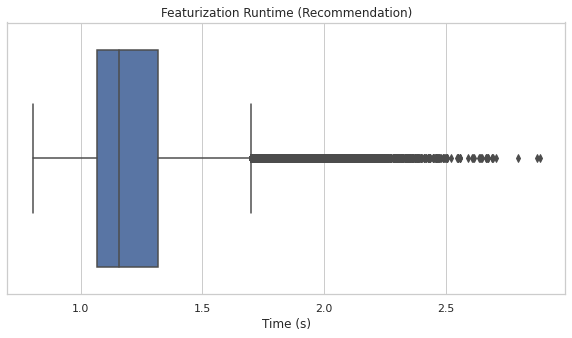

In [53]:
plt.tight_layout()

f, ax = plt.subplots(ncols=1, figsize=(10, 5))
   
sns.boxplot(x=runtimes["runtimes"])
ax.set(title="Featurization Runtime (Recommendation)", xlabel="Time (s)")
 

In [54]:
avg_runtime = runtimes.runtimes.mean()
avg_runtime

1.2106441884733483

In [55]:
split = 0.75 
#updates_per_ts = [0.5, 0.25, 0.2, 1, 2, 3, 4, 5, 8, 10000, None]
updates_per_ts = [0.5, 0.25, 0.2, 1, 2, 3, 4, 5, 8, None, 10000] #, 3, 4, 5, 8]
ts_factor = [60] #, 60*60, 60*60*24]
policies = ["random", "total_error_cold", "query_proportional", "max_pending", "min_past", "round_robin", "batch"] #, "last_query"]
dist = ["exponential", "gaussian", None]

In [57]:
limit = 10000

In [58]:
stream_df = pd.read_csv(f'{dataset_dir}/stream_{split}.csv')
start_ts = stream_df.timestamp.min()
stream_df.timestamp = stream_df.timestamp.apply(lambda ts: ts - start_ts)
stream_df

,user_id,movie_id,rating,timestamp
0,1,661,3,3081168
1,1,914,3,3081027
2,1,3408,4,3079334
3,1,2355,5,3603350
4,1,1197,3,3081327
...,...,...,...,...
249907,6040,1333,4,22233199
249908,6040,3362,4,22232855
249909,6040,161,3,22233545
249910,6040,2725,4,22233239


# Collect Baselines 

In [59]:
results = []

for baseline in [None, 10000]:
    for t in ts_factor: 
        for d in dist: 
            
            if d: 
                update_df = pd.read_csv(f"{result_dir}/round_robin_{baseline}_{t}_split_{split}_dist_{d}_updates.csv")
                df = pd.read_csv(f"{result_dir}/round_robin_{baseline}_{t}_split_{split}_dist_{d}_results.csv")
            else: 
                update_df = pd.read_csv(f"{result_dir}/round_robin_{baseline}_{t}_split_{split}_updates.csv")
                df = pd.read_csv(f"{result_dir}/round_robin_{baseline}_{t}_split_{split}_results.csv")
                
            print(len(df.index))
            df = df.iloc[:limit]

            timestamp = df.timestamp.max()
            update_df = update_df[update_df["time"] < timestamp]

            error = mean_squared_error(df.y_pred, df.y_true)
            total_updates = len(update_df.index)

            if baseline is None:
                results.append([0, error, total_updates, t, df.timestamp.max(), d])
            else: 
                results.append([baseline, error, total_updates, t, df.timestamp.max(), d])
        
baseline_results_df = pd.DataFrame(results, columns=["updates", "error", "total_updates", "ts_factor", "max_ts", "dist"])
baseline_results_df

122656
122656
249912
122656
122656
249912


,updates,error,total_updates,ts_factor,max_ts,dist
0,0,4.968573,0,60,2376,exponential
1,0,4.968573,0,60,2408,gaussian
2,0,4.966949,0,60,2169,None
3,10000,1.100133,4101,60,2376,exponential
4,10000,1.090638,4117,60,2408,gaussian
5,10000,1.135755,2210,60,2169,None


In [60]:
updates_df = pd.DataFrame()
df_all = pd.DataFrame()
results = [] 

for p in policies: 
    for u in updates_per_ts: 
        for t in ts_factor: 
            
            for d in dist: 
            
                if d:
                    path = f"{result_dir}/{p}_{u}_{t}_split_{split}_dist_{d}"
                else: 
                    path = f"{result_dir}/{p}_{u}_{t}_split_{split}"
                    
                if not os.path.exists(f"{path}_updates.csv"): 
                    print("missing", f"{path}_updates.csv")
                    continue

                update_df = pd.read_csv(f"{path}_updates.csv")
                df = pd.read_csv(f"{path}_results.csv")


                if limit is not None:
                    if len(df.index) <= limit: 
                        print("max index", len(df.index), f"{result_dir}/{p}_{u}_{t}_split_{split}_results.csv")
                        continue 

                    # filter time 
                    df = df.iloc[:limit]
                    timestamp = df.timestamp.max()
                    update_df = update_df[update_df["time"] < timestamp]

                print(p, u, t, df.timestamp.max(), update_df["time"].max())

                df["policy"] = p
                df["updates"] = u 
                df["ts_factor"] = t
                df["dist"] = d
                update_df["updates"] = u 
                update_df["ts_factor"] = t
                update_df["dist"] = d

                # threshold predictions 
                df["y_pred"][df["y_pred"] > 5] = 5
                df["y_pred"][df["y_pred"] < 1] = 1

                #print(df.y_pred)
                #print(df.y_true)

                error = mean_squared_error(df.y_pred, df.y_true)

                #print(update_df.time.value_counts())


                total_updates = len(update_df.index)
                print(total_updates, len(df.index), error)
                results.append([u , p, error, total_updates, t, df.timestamp.max(), d])
                updates_df = pd.concat([updates_df, update_df])
                df_all = pd.concat([df_all, df])
      
results_df = pd.DataFrame(results, columns=["updates", "policy", "error", "total_updates", "ts_factor", "max_ts", "dist"])
results_df

random 0.5 60 2376 2375
1177 10000 1.3405631518897112
random 0.5 60 2408 2407
1196 10000 1.243398686600159


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1
<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set

random 0.5 60 2169 2167
513 10000 1.7594951498202525
random 0.25 60 2376 2375
592 10000 1.6973879025623606
random 0.25 60 2408 2405
600 10000 1.8218737325018113


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1
<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set

random 0.25 60 2169 2165
268 10000 2.9582412596038252
random 0.2 60 2376 2375
475 10000 1.810790113057936
random 0.2 60 2408 2406
481 10000 1.853530250084438


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1
<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set

random 0.2 60 2169 2165
220 10000 3.0817528106276733
random 1 60 2376 2375
2345 10000 1.1736228600617595


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1
<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set

random 1 60 2408 2407
2369 10000 1.1516707056760678
random 1 60 2169 2168
987 10000 1.3070511981961626


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1
<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set

random 2 60 2376 2375
3736 10000 1.1084305116052158
random 2 60 2408 2407
3756 10000 1.1020551379666086


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1
<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set

random 2 60 2169 2168
1651 10000 1.1695571043299526
random 3 60 2376 2375
4061 10000 1.1010576873075983


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1
<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set

random 3 60 2408 2407
4078 10000 1.0897166945617045
random 3 60 2169 2168


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1
<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set

2013 10000 1.158039648384269
random 4 60 2376 2375
4099 10000 1.1001334293277822
random 4 60 2408 2407
4116 10000 1.0906382467596036
random 4 60 2169 2168


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1
<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set

2161 10000 1.1371276371657755
missing /data/wooders/ralf-vldb/results/ml-1m/random_5_60_split_0.75_dist_exponential_updates.csv
missing /data/wooders/ralf-vldb/results/ml-1m/random_5_60_split_0.75_dist_gaussian_updates.csv
random 5 60 2169 2168
2203 10000 1.1359678789995435
missing /data/wooders/ralf-vldb/results/ml-1m/random_8_60_split_0.75_dist_exponential_updates.csv
missing /data/wooders/ralf-vldb/results/ml-1m/random_8_60_split_0.75_dist_gaussian_updates.csv
random 8 60 2169 2168
2210 10000 1.1357546377067504


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1
<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set

random None 60 2376 nan
0 10000 4.968573254767408
random None 60 2408 nan
0 10000 4.968573254767408
missing /data/wooders/ralf-vldb/results/ml-1m/random_None_60_split_0.75_updates.csv


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1
<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set

random 10000 60 2376 2375
4101 10000 1.100133457706349
random 10000 60 2408 2407
4117 10000 1.0906382492812106


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1
<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set

missing /data/wooders/ralf-vldb/results/ml-1m/random_10000_60_split_0.75_updates.csv
total_error_cold 0.5 60 2376 2375
1177 10000 1.1356757273332063
total_error_cold 0.5 60 2408 2407
1196 10000 1.1319298660233421


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


total_error_cold 0.5 60 2169 2167
513 10000 1.2212354699988297
total_error_cold 0.25 60 2376 2375
592 10000 1.184443844541003


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1
<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set

total_error_cold 0.25 60 2408 2405
600 10000 1.2014395669700033


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


total_error_cold 0.25 60 2169 2165
268 10000 1.3437958755802926
total_error_cold 0.2 60 2376 2375
475 10000 1.2021232774787283


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1
<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set

total_error_cold 0.2 60 2408 2406
481 10000 1.2352823029386897


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


total_error_cold 0.2 60 2169 2165
220 10000 1.4507793860054188
total_error_cold 1 60 2376 2375
2345 10000 1.1082891854931847


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1
<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set

total_error_cold 1 60 2408 2407
2369 10000 1.0992899477110651


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


total_error_cold 1 60 2169 2168
987 10000 1.1487731297582364
total_error_cold 2 60 2376 2375
3762 10000 1.0998464344699646


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1
<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set

total_error_cold 2 60 2408 2407
3778 10000 1.0919788056804511


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


total_error_cold 2 60 2169 2168
1678 10000 1.1383266532575296
total_error_cold 3 60 2376 2375
4060 10000 1.1002425612750164


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1
<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set

total_error_cold 3 60 2408 2407
4077 10000 1.0911169206783173


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


total_error_cold 3 60 2169 2168
2028 10000 1.135321902954237
total_error_cold 4 60 2376 2375
4099 10000 1.100133462276651


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1
<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set

total_error_cold 4 60 2408 2407
4116 10000 1.0906382508525967


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


total_error_cold 4 60 2169 2168
2165 10000 1.1358981707749483
missing /data/wooders/ralf-vldb/results/ml-1m/total_error_cold_5_60_split_0.75_dist_exponential_updates.csv
missing /data/wooders/ralf-vldb/results/ml-1m/total_error_cold_5_60_split_0.75_dist_gaussian_updates.csv


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


total_error_cold 5 60 2169 2168
2204 10000 1.1357546509901009
missing /data/wooders/ralf-vldb/results/ml-1m/total_error_cold_8_60_split_0.75_dist_exponential_updates.csv
missing /data/wooders/ralf-vldb/results/ml-1m/total_error_cold_8_60_split_0.75_dist_gaussian_updates.csv


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


total_error_cold 8 60 2169 2168
2210 10000 1.1357546377067504
total_error_cold None 60 2376 nan
0 10000 4.968573254767408


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1
<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set

total_error_cold None 60 2408 nan
0 10000 4.968573254767408
missing /data/wooders/ralf-vldb/results/ml-1m/total_error_cold_None_60_split_0.75_updates.csv
total_error_cold 10000 60 2376 2375
4101 10000 1.100133457706349


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1
<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set

total_error_cold 10000 60 2408 2407
4117 10000 1.0906382492812106
missing /data/wooders/ralf-vldb/results/ml-1m/total_error_cold_10000_60_split_0.75_updates.csv
query_proportional 0.5 60 2376 2375
1177 10000 1.2959890424568055


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1
<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set

query_proportional 0.5 60 2408 2407
1196 10000 1.2798517721698426


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


query_proportional 0.5 60 2169 2167
513 10000 1.7680860460496874
query_proportional 0.25 60 2376 2375
592 10000 1.6030778704351365


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1
<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set

query_proportional 0.25 60 2408 2405
600 10000 1.6066082999396512


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


query_proportional 0.25 60 2169 2165
268 10000 2.2569861708554417
query_proportional 0.2 60 2376 2375


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1
<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set

475 10000 1.7729557657918438
query_proportional 0.2 60 2408 2406
481 10000 1.7391336897393055


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


query_proportional 0.2 60 2169 2165
220 10000 2.5005773746664337


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


query_proportional 1 60 2376 2375
2345 10000 1.146022694029641


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


query_proportional 1 60 2408 2407
2369 10000 1.155358596269543


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


query_proportional 1 60 2169 2168
987 10000 1.3834462274224504


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


query_proportional 2 60 2376 2375
3757 10000 1.1035161861544935


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


query_proportional 2 60 2408 2407
3791 10000 1.0914040135543335


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


query_proportional 2 60 2169 2168
1682 10000 1.1864032294758393


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


query_proportional 3 60 2376 2375
4063 10000 1.100242733404916


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


query_proportional 3 60 2408 2407
4080 10000 1.0906381511178487


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


query_proportional 3 60 2169 2168
2031 10000 1.1490270722723


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


query_proportional 4 60 2376 2375
4099 10000 1.1001334566140288


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


query_proportional 4 60 2408 2407
4117 10000 1.0906382479981227


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


query_proportional 4 60 2169 2168
2170 10000 1.1358980210901928
missing /data/wooders/ralf-vldb/results/ml-1m/query_proportional_5_60_split_0.75_dist_exponential_updates.csv
missing /data/wooders/ralf-vldb/results/ml-1m/query_proportional_5_60_split_0.75_dist_gaussian_updates.csv


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


query_proportional 5 60 2169 2168
2204 10000 1.1357546352084809
missing /data/wooders/ralf-vldb/results/ml-1m/query_proportional_8_60_split_0.75_dist_exponential_updates.csv
missing /data/wooders/ralf-vldb/results/ml-1m/query_proportional_8_60_split_0.75_dist_gaussian_updates.csv


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


query_proportional 8 60 2169 2168
2210 10000 1.1357546377067504


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


query_proportional None 60 2376 nan
0 10000 4.968573254767408


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


query_proportional None 60 2408 nan
0 10000 4.968573254767408
missing /data/wooders/ralf-vldb/results/ml-1m/query_proportional_None_60_split_0.75_updates.csv


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


query_proportional 10000 60 2376 2375
4101 10000 1.100133457706349


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


query_proportional 10000 60 2408 2407
4117 10000 1.0906382492812106
missing /data/wooders/ralf-vldb/results/ml-1m/query_proportional_10000_60_split_0.75_updates.csv


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


max_pending 0.5 60 2376 2375
1177 10000 1.2959890424568055


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


max_pending 0.5 60 2408 2407
1196 10000 1.2798517721698426


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


max_pending 0.5 60 2169 2167
513 10000 1.768086046049689


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


max_pending 0.25 60 2376 2375
592 10000 1.6030778704351365


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


max_pending 0.25 60 2408 2405
600 10000 1.6066082999396512


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


max_pending 0.25 60 2169 2165
268 10000 2.2569861708554417


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


max_pending 0.2 60 2376 2375
475 10000 1.7729557657918438


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


max_pending 0.2 60 2408 2406
481 10000 1.7391336897393055


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


max_pending 0.2 60 2169 2165
220 10000 2.5005773746664324


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


max_pending 1 60 2376 2375
2345 10000 1.146022694029641


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


max_pending 1 60 2408 2407
2369 10000 1.155358596269543


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


max_pending 1 60 2169 2168
987 10000 1.3834462274224504


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


max_pending 2 60 2376 2375
3757 10000 1.1035161861544935


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


max_pending 2 60 2408 2407
3791 10000 1.0914040135543335


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


max_pending 2 60 2169 2168
1682 10000 1.1864032294758409


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


max_pending 3 60 2376 2375
4063 10000 1.100242733404916


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


max_pending 3 60 2408 2407
4080 10000 1.0906381511178487


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


max_pending 3 60 2169 2168
2031 10000 1.1490270722723


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


max_pending 4 60 2376 2375
4099 10000 1.1001334566140288


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


max_pending 4 60 2408 2407
4117 10000 1.0906382479981227


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


max_pending 4 60 2169 2168
2170 10000 1.1358980210901928


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


missing /data/wooders/ralf-vldb/results/ml-1m/max_pending_5_60_split_0.75_dist_exponential_updates.csv
missing /data/wooders/ralf-vldb/results/ml-1m/max_pending_5_60_split_0.75_dist_gaussian_updates.csv
max_pending 5 60 2169 2168
2204 10000 1.1357546352084809


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


missing /data/wooders/ralf-vldb/results/ml-1m/max_pending_8_60_split_0.75_dist_exponential_updates.csv
missing /data/wooders/ralf-vldb/results/ml-1m/max_pending_8_60_split_0.75_dist_gaussian_updates.csv
max_pending 8 60 2169 2168
2210 10000 1.1357546377067504


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


max_pending None 60 2376 nan
0 10000 4.968573254767408


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


max_pending None 60 2408 nan
0 10000 4.968573254767408


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


missing /data/wooders/ralf-vldb/results/ml-1m/max_pending_None_60_split_0.75_updates.csv
max_pending 10000 60 2376 2375
4101 10000 1.100133457706349


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


max_pending 10000 60 2408 2407
4117 10000 1.0906382492812106


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


missing /data/wooders/ralf-vldb/results/ml-1m/max_pending_10000_60_split_0.75_updates.csv
min_past 0.5 60 2376 2375
1177 10000 1.18502429230722


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


min_past 0.5 60 2408 2407
1196 10000 1.1773865707814806


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


min_past 0.5 60 2169 2167
513 10000 1.291339043878491


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


min_past 0.25 60 2376 2375
592 10000 1.2704816118529783


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


min_past 0.25 60 2408 2405
600 10000 1.2885737638092851


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


min_past 0.25 60 2169 2165
268 10000 1.40127128479549


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


min_past 0.2 60 2376 2375
475 10000 1.2916059920213432


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


min_past 0.2 60 2408 2406
481 10000 1.3128295328789987


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


min_past 0.2 60 2169 2165
220 10000 1.5024664330776039


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


min_past 1 60 2376 2375
2345 10000 1.1381287204515373


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


min_past 1 60 2408 2407
2369 10000 1.1354548345445663


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


min_past 1 60 2169 2168
987 10000 1.2162851203696972


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


min_past 2 60 2376 2375
3753 10000 1.1037426747956045


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


min_past 2 60 2408 2407
3760 10000 1.0929374856594285


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


min_past 2 60 2169 2168
1664 10000 1.1587740108854707


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


min_past 3 60 2376 2375
4059 10000 1.1003509824704734


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


min_past 3 60 2408 2407
4071 10000 1.0906391880507302


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


min_past 3 60 2169 2168
2012 10000 1.1382188629566916


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


min_past 4 60 2376 2375
4101 10000 1.100133438970672


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


min_past 4 60 2408 2407
4117 10000 1.090638255304247


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


min_past 4 60 2169 2168
2158 10000 1.1364576700226292


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


missing /data/wooders/ralf-vldb/results/ml-1m/min_past_5_60_split_0.75_dist_exponential_updates.csv
missing /data/wooders/ralf-vldb/results/ml-1m/min_past_5_60_split_0.75_dist_gaussian_updates.csv
min_past 5 60 2169 2168
2202 10000 1.1360091561864691


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


missing /data/wooders/ralf-vldb/results/ml-1m/min_past_8_60_split_0.75_dist_exponential_updates.csv
missing /data/wooders/ralf-vldb/results/ml-1m/min_past_8_60_split_0.75_dist_gaussian_updates.csv
min_past 8 60 2169 2168
2210 10000 1.1357546377067504


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


min_past None 60 2376 nan
0 10000 4.968573254767408


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


min_past None 60 2408 nan
0 10000 4.968573254767408


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


missing /data/wooders/ralf-vldb/results/ml-1m/min_past_None_60_split_0.75_updates.csv
min_past 10000 60 2376 2375
4101 10000 1.100133457706349


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


min_past 10000 60 2408 2407
4117 10000 1.0906382492812106


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


missing /data/wooders/ralf-vldb/results/ml-1m/min_past_10000_60_split_0.75_updates.csv
round_robin 0.5 60 2376 2375
1177 10000 1.1744502432883261


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


round_robin 0.5 60 2408 2407
1196 10000 1.1384614873125205


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


round_robin 0.5 60 2169 2167
513 10000 1.8967591096614655


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


round_robin 0.25 60 2376 2375
592 10000 1.256623046262641


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


round_robin 0.25 60 2408 2405
600 10000 1.3155332812707679


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


round_robin 0.25 60 2169 2165
268 10000 1.9197572091191173


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


round_robin 0.2 60 2376 2375
475 10000 1.3498660824608604


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


round_robin 0.2 60 2408 2406
481 10000 1.3545411539582142


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


round_robin 0.2 60 2169 2165
220 10000 3.6081761903691136


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


round_robin 1 60 2376 2375
2345 10000 1.1071263480575688


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


round_robin 1 60 2408 2407
2369 10000 1.0963522679720425


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


round_robin 1 60 2169 2168
987 10000 1.2785568718813303


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


round_robin 2 60 2376 2375
3764 10000 1.0997616755916633


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


round_robin 2 60 2408 2407
3771 10000 1.0906384150685735


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


round_robin 2 60 2169 2168
1659 10000 1.1368909542342256


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


round_robin 3 60 2376 2375
4061 10000 1.1001335111362756


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


round_robin 3 60 2408 2407
4076 10000 1.0906381903308933


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


round_robin 3 60 2169 2168
2013 10000 1.1365964921959313


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


round_robin 4 60 2376 2375
4099 10000 1.1001334556540063


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


round_robin 4 60 2408 2407
4117 10000 1.0906382493354578


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


round_robin 4 60 2169 2168
2158 10000 1.135560827909751


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


missing /data/wooders/ralf-vldb/results/ml-1m/round_robin_5_60_split_0.75_dist_exponential_updates.csv
missing /data/wooders/ralf-vldb/results/ml-1m/round_robin_5_60_split_0.75_dist_gaussian_updates.csv
round_robin 5 60 2169 2168
2202 10000 1.135759930809384


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


missing /data/wooders/ralf-vldb/results/ml-1m/round_robin_8_60_split_0.75_dist_exponential_updates.csv
missing /data/wooders/ralf-vldb/results/ml-1m/round_robin_8_60_split_0.75_dist_gaussian_updates.csv
round_robin 8 60 2169 2168
2210 10000 1.1357546377067504


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


round_robin None 60 2376 nan
0 10000 4.968573254767408


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


round_robin None 60 2408 nan
0 10000 4.968573254767408


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


round_robin None 60 2169 nan
0 10000 4.966949289411807


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


round_robin 10000 60 2376 2375
4101 10000 1.100133457706349


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


round_robin 10000 60 2408 2407
4117 10000 1.0906382492812106


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


round_robin 10000 60 2169 2168
2210 10000 1.1357546377067504


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


missing /data/wooders/ralf-vldb/results/ml-1m/batch_0.5_60_split_0.75_dist_exponential_updates.csv
missing /data/wooders/ralf-vldb/results/ml-1m/batch_0.5_60_split_0.75_dist_gaussian_updates.csv
batch 0.5 60 2169 2161
490 10000 1.8068793618625074


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


missing /data/wooders/ralf-vldb/results/ml-1m/batch_0.25_60_split_0.75_dist_exponential_updates.csv
missing /data/wooders/ralf-vldb/results/ml-1m/batch_0.25_60_split_0.75_dist_gaussian_updates.csv
batch 0.25 60 2169 977
190 10000 3.305518311922317


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


missing /data/wooders/ralf-vldb/results/ml-1m/batch_0.2_60_split_0.75_dist_exponential_updates.csv
missing /data/wooders/ralf-vldb/results/ml-1m/batch_0.2_60_split_0.75_dist_gaussian_updates.csv
batch 0.2 60 2169 942
145 10000 3.5376021739275645


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


missing /data/wooders/ralf-vldb/results/ml-1m/batch_1_60_split_0.75_dist_exponential_updates.csv
missing /data/wooders/ralf-vldb/results/ml-1m/batch_1_60_split_0.75_dist_gaussian_updates.csv
batch 1 60 2169 2165
984 10000 1.31146852195022


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


missing /data/wooders/ralf-vldb/results/ml-1m/batch_2_60_split_0.75_dist_exponential_updates.csv
missing /data/wooders/ralf-vldb/results/ml-1m/batch_2_60_split_0.75_dist_gaussian_updates.csv
batch 2 60 2169 2168
1537 10000 1.1753167465026444


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


missing /data/wooders/ralf-vldb/results/ml-1m/batch_3_60_split_0.75_dist_exponential_updates.csv
missing /data/wooders/ralf-vldb/results/ml-1m/batch_3_60_split_0.75_dist_gaussian_updates.csv
batch 3 60 2169 2168
1862 10000 1.1568934487483384


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


missing /data/wooders/ralf-vldb/results/ml-1m/batch_4_60_split_0.75_dist_exponential_updates.csv
missing /data/wooders/ralf-vldb/results/ml-1m/batch_4_60_split_0.75_dist_gaussian_updates.csv
batch 4 60 2169 2168
2075 10000 1.1393625196765318


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


missing /data/wooders/ralf-vldb/results/ml-1m/batch_5_60_split_0.75_dist_exponential_updates.csv
missing /data/wooders/ralf-vldb/results/ml-1m/batch_5_60_split_0.75_dist_gaussian_updates.csv
batch 5 60 2169 2168
2177 10000 1.136124746493405


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


missing /data/wooders/ralf-vldb/results/ml-1m/batch_8_60_split_0.75_dist_exponential_updates.csv
missing /data/wooders/ralf-vldb/results/ml-1m/batch_8_60_split_0.75_dist_gaussian_updates.csv
batch 8 60 2169 2168
2210 10000 1.1357546377067504


<ipython-input-60-1788d9335322>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
<ipython-input-60-1788d9335322>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


missing /data/wooders/ralf-vldb/results/ml-1m/batch_None_60_split_0.75_dist_exponential_updates.csv
missing /data/wooders/ralf-vldb/results/ml-1m/batch_None_60_split_0.75_dist_gaussian_updates.csv
missing /data/wooders/ralf-vldb/results/ml-1m/batch_None_60_split_0.75_updates.csv
missing /data/wooders/ralf-vldb/results/ml-1m/batch_10000_60_split_0.75_dist_exponential_updates.csv
missing /data/wooders/ralf-vldb/results/ml-1m/batch_10000_60_split_0.75_dist_gaussian_updates.csv
missing /data/wooders/ralf-vldb/results/ml-1m/batch_10000_60_split_0.75_updates.csv


,updates,policy,error,total_updates,ts_factor,max_ts,dist
0,0.50,random,1.340563,1177,60,2376,exponential
1,0.50,random,1.243399,1196,60,2408,gaussian
2,0.50,random,1.759495,513,60,2169,None
3,0.25,random,1.697388,592,60,2376,exponential
4,0.25,random,1.821874,600,60,2408,gaussian
...,...,...,...,...,...,...,...
168,2.00,batch,1.175317,1537,60,2169,None
169,3.00,batch,1.156893,1862,60,2169,None
170,4.00,batch,1.139363,2075,60,2169,None
171,5.00,batch,1.136125,2177,60,2169,None


In [61]:
plots_dir = use_plots("ml-1m-dist")
df_all.to_csv(f"{plots_dir}/predictions.csv")
results_df.to_csv(f"{plots_dir}/results.csv")
baseline_results_df.to_csv(f"{plots_dir}/baseline.csv")
updates_df.to_csv(f"{plots_dir}/updates.csv")
log_plots("ml-1m-dist")

{'results_dir': '/data/wooders/ralf-vldb/results', 'dataset_dir': '/data/wooders/ralf-vldb/datasets', 'plots_dir': '/data/wooders/ralf-vldb/plots', 'aws_dir': 'vldb', 'credentials': '/home/eecs/wooders/experiments/ralf-vldb.json'}
uploading /data/wooders/ralf-vldb/plots ml-1m-dist
vldb/plots ml-1m-dist /ml-1m-dist/updates.csv
uploading /data/wooders/ralf-vldb/plots/ml-1m-dist vldb/plots vldb/plots/ml-1m-dist/updates.csv
vldb/plots ml-1m-dist /ml-1m-dist/predictions.csv
uploading /data/wooders/ralf-vldb/plots/ml-1m-dist vldb/plots vldb/plots/ml-1m-dist/predictions.csv
vldb/plots ml-1m-dist /ml-1m-dist/baseline.csv
uploading /data/wooders/ralf-vldb/plots/ml-1m-dist vldb/plots vldb/plots/ml-1m-dist/baseline.csv
vldb/plots ml-1m-dist /ml-1m-dist/results.csv
uploading /data/wooders/ralf-vldb/plots/ml-1m-dist vldb/plots vldb/plots/ml-1m-dist/results.csv


'vldb/plots/ml-1m-dist'

In [62]:
results_df

,updates,policy,error,total_updates,ts_factor,max_ts,dist
0,0.50,random,1.340563,1177,60,2376,exponential
1,0.50,random,1.243399,1196,60,2408,gaussian
2,0.50,random,1.759495,513,60,2169,None
3,0.25,random,1.697388,592,60,2376,exponential
4,0.25,random,1.821874,600,60,2408,gaussian
...,...,...,...,...,...,...,...
168,2.00,batch,1.175317,1537,60,2169,None
169,3.00,batch,1.156893,1862,60,2169,None
170,4.00,batch,1.139363,2075,60,2169,None
171,5.00,batch,1.136125,2177,60,2169,None


In [63]:
results_df

,updates,policy,error,total_updates,ts_factor,max_ts,dist
0,0.50,random,1.340563,1177,60,2376,exponential
1,0.50,random,1.243399,1196,60,2408,gaussian
2,0.50,random,1.759495,513,60,2169,None
3,0.25,random,1.697388,592,60,2376,exponential
4,0.25,random,1.821874,600,60,2408,gaussian
...,...,...,...,...,...,...,...
168,2.00,batch,1.175317,1537,60,2169,None
169,3.00,batch,1.156893,1862,60,2169,None
170,4.00,batch,1.139363,2075,60,2169,None
171,5.00,batch,1.136125,2177,60,2169,None


In [64]:
df_all

,Unnamed: 0,y_true,y_pred,user_id,movie_id,timestamp,policy,updates,ts_factor,dist
0,0,4,5.000000,897,3147,0,random,0.5,60,exponential
1,1,1,2.864905,1010,2394,0,random,0.5,60,exponential
2,2,2,2.275176,1010,2294,0,random,0.5,60,exponential
3,3,2,2.510539,1010,588,0,random,0.5,60,exponential
4,4,2,3.103672,1010,364,0,random,0.5,60,exponential
...,...,...,...,...,...,...,...,...,...,...
9995,9995,4,4.164848,848,2396,2169,batch,8,60,None
9996,9996,3,3.969520,850,596,2169,batch,8,60,None
9997,9997,3,3.925536,850,3271,2169,batch,8,60,None
9998,9998,3,4.241657,850,3547,2169,batch,8,60,None


In [65]:
results_df[results_df["ts_factor"] == 60]

,updates,policy,error,total_updates,ts_factor,max_ts,dist
0,0.50,random,1.340563,1177,60,2376,exponential
1,0.50,random,1.243399,1196,60,2408,gaussian
2,0.50,random,1.759495,513,60,2169,None
3,0.25,random,1.697388,592,60,2376,exponential
4,0.25,random,1.821874,600,60,2408,gaussian
...,...,...,...,...,...,...,...
168,2.00,batch,1.175317,1537,60,2169,None
169,3.00,batch,1.156893,1862,60,2169,None
170,4.00,batch,1.139363,2075,60,2169,None
171,5.00,batch,1.136125,2177,60,2169,None


In [66]:
def plot_factor_total_updates(ts_factor_filter, subset, log=False):

    f, ax = plt.subplots(ncols=1, figsize=(8, 5))
    plt.tight_layout()
    sns.set_theme(style="whitegrid", font_scale=1.7)
    #ts_factor_filter = 60

    plot_df = results_df[(results_df["ts_factor"] == ts_factor_filter) & (results_df.policy.isin(subset))]
    plot_df.policy = plot_df.policy.map({
        'total_error_cold': 'Regret Optimized', 
        'min_past': 'Minumum Past', 
        'round_robin': "Round-Robin", 
        'max_pending': "Maximum Pending Updates", 
        'last_query': "Read-Optimized", 
        "query_proportional": "Query Proportional",
        "batch": "Batched",
        "random": "Random"
    })
    
    plot_df = plot_df.dropna()
    
    if log: 
        plot_df.error = np.log2(plot_df.error)
        
    sns.lineplot(x="total_updates", y="error", hue="policy", data=plot_df, ax=ax, linewidth=3)
    #ax.set(title="Prediction Accuracy per Policy (Recommendation)", xlabel="Total Featurization Updates",  ylabel="MSE")
    
    if log: 
        ax.set(title="", xlabel="Total Featurization Updates",  ylabel="Log2 MSE")
    else:
        ax.set(title="", xlabel="Total Featurization Updates",  ylabel="MSE")
    ax.set(xscale="log")
    
    upper_bound = baseline_results_df[(baseline_results_df["updates"] == 10000) & (baseline_results_df["ts_factor"] == ts_factor_filter)].error.iloc[0]
    upper_bound_updates = baseline_results_df[(baseline_results_df["updates"] == 10000) & (baseline_results_df["ts_factor"] == ts_factor_filter)].total_updates.iloc[0]
    lower_bound = baseline_results_df[(baseline_results_df["updates"] == 0) & (baseline_results_df["ts_factor"] == ts_factor_filter)].error.iloc[0]
    lower_bound_updates = baseline_results_df[(baseline_results_df["updates"] == 0) & (baseline_results_df["ts_factor"] == ts_factor_filter)].total_updates.iloc[0]
    print(upper_bound, upper_bound_updates)
    
    return plt
    
    if log: 
        plt.axline((0, np.log2(upper_bound)), (1, np.log2(upper_bound)), color='black', linestyle="--")
    else:
        plt.axline((0, upper_bound), (1, upper_bound), color='black', linestyle="--")
        
    plt.axvline(upper_bound_updates, color='black', linestyle="--")
    
    #plt.axline((0, lower_bound), (1, lower_bound), color='black', linestyle="--")
    #plt.axvline(lower_bound_updates, linewidth=3, color='black', linestyle="--")
    #plt.legend(loc='upper right')
    
    #plt.scatter(upper_bound_updates, upper_bound, marker='o', s=100)
    #plt.scatter(lower_bound_updates, lower_bound, marker='o', s=100)
    
    return plt
    


In [67]:
def plot_factor(ts_factor_filter, subset, updates):

    f, ax = plt.subplots(ncols=1, figsize=(8, 5))
    plt.tight_layout()
    sns.set_theme(style="whitegrid", font_scale=1.7)
    #ts_factor_filter = 60

    plot_df = results_df[(results_df["ts_factor"] == ts_factor_filter) & (results_df.policy.isin(subset)) & (results_df.updates.isin(updates))]
    plot_df.policy = plot_df.policy.map({
        'total_error_cold': 'Regret Optimized', 
        'min_past': 'Minimum Past', 
        'round_robin': "Round-Robin", 
        'max_pending': "Maximum Pending Updates", 
        'last_query': "Read-Optimized", 
        "query_proportional": "Query Proportional",
        "batch": "Batched"
    })
    plot_df = plot_df.dropna()
    print(plot_df)
    sns.barplot(x="updates", y="error", hue="policy", data=plot_df, log=False, ax=ax)
    #ax.set(title="Prediction Error per Policy (Recommendation)", xlabel="Budget (Updates per Timestep)",  ylabel="Log MSE")
    
    ax.set(title="", xlabel="Budget (Updates per Timestep)",  ylabel="Log MSE")
    
    upper_bound = baseline_results_df[(baseline_results_df["updates"] == 10000) & (baseline_results_df["ts_factor"] == ts_factor_filter)].error.iloc[0]
    lower_bound = baseline_results_df[(baseline_results_df["updates"] == 0) & (baseline_results_df["ts_factor"] == ts_factor_filter)].error.iloc[0]

    #plt.axline((0, lower_bound), (1, lower_bound), color='r')
    plt.axline((0, upper_bound), (1, upper_bound), linewidth=3, color='g')
    
    margin = (plot_df.error.max() - upper_bound)/10
    plt.ylim([upper_bound - margin, plot_df.error.max() + margin])
    
    return plt 
    
    

/data/wooders/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


     updates                   policy     error  total_updates  ts_factor  \
27       0.5         Regret Optimized  1.135676           1177         60   
28       0.5         Regret Optimized  1.131930           1196         60   
36       1.0         Regret Optimized  1.108289           2345         60   
37       1.0         Regret Optimized  1.099290           2369         60   
39       2.0         Regret Optimized  1.099846           3762         60   
40       2.0         Regret Optimized  1.091979           3778         60   
54       0.5       Query Proportional  1.295989           1177         60   
55       0.5       Query Proportional  1.279852           1196         60   
63       1.0       Query Proportional  1.146023           2345         60   
64       1.0       Query Proportional  1.155359           2369         60   
66       2.0       Query Proportional  1.103516           3757         60   
67       2.0       Query Proportional  1.091404           3791         60   

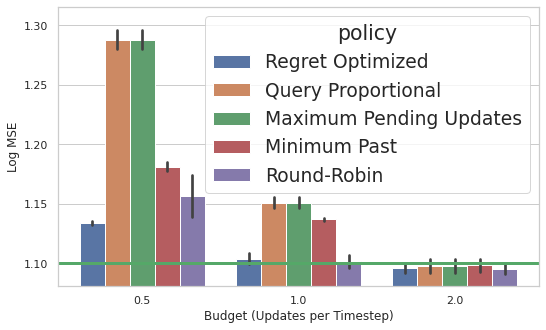

In [68]:
subset = ["random", "total_error_cold", "min_past", "round_robin", "max_pending", "last_query", "query_proportional", "batch"]
#subset = ["total_error_cold", "min_past"]

plt = plot_factor(60, subset, updates=[0.5, 1, 2])
plt.tight_layout()
plt.savefig('/data/wooders/ralf-vldb/plots/als_1m_bar_1.pdf') 

/data/wooders/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


     updates            policy     error  total_updates  ts_factor  max_ts  \
36       1.0  Regret Optimized  1.108289           2345         60    2376   
37       1.0  Regret Optimized  1.099290           2369         60    2408   
39       2.0  Regret Optimized  1.099846           3762         60    2376   
40       2.0  Regret Optimized  1.091979           3778         60    2408   
42       3.0  Regret Optimized  1.100243           4060         60    2376   
43       3.0  Regret Optimized  1.091117           4077         60    2408   
45       4.0  Regret Optimized  1.100133           4099         60    2376   
46       4.0  Regret Optimized  1.090638           4116         60    2408   
117      1.0      Minimum Past  1.138129           2345         60    2376   
118      1.0      Minimum Past  1.135455           2369         60    2408   
120      2.0      Minimum Past  1.103743           3753         60    2376   
121      2.0      Minimum Past  1.092937           3760         

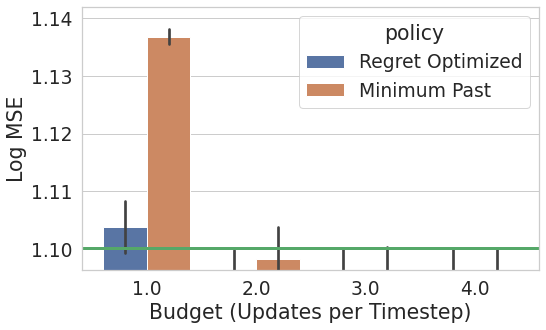

In [69]:
subset = ["total_error_cold", "min_past"]

plot_factor(60, subset, updates=[1, 2, 3, 4, 6, 8])
plt.tight_layout()
plt.savefig('/data/wooders/ralf-vldb/plots/als_1m_bar_2.pdf') 

/data/wooders/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


     updates                   policy     error  total_updates  ts_factor  \
27       0.5         Regret Optimized  1.135676           1177         60   
28       0.5         Regret Optimized  1.131930           1196         60   
36       1.0         Regret Optimized  1.108289           2345         60   
37       1.0         Regret Optimized  1.099290           2369         60   
39       2.0         Regret Optimized  1.099846           3762         60   
40       2.0         Regret Optimized  1.091979           3778         60   
42       3.0         Regret Optimized  1.100243           4060         60   
43       3.0         Regret Optimized  1.091117           4077         60   
45       4.0         Regret Optimized  1.100133           4099         60   
46       4.0         Regret Optimized  1.090638           4116         60   
54       0.5       Query Proportional  1.295989           1177         60   
55       0.5       Query Proportional  1.279852           1196         60   

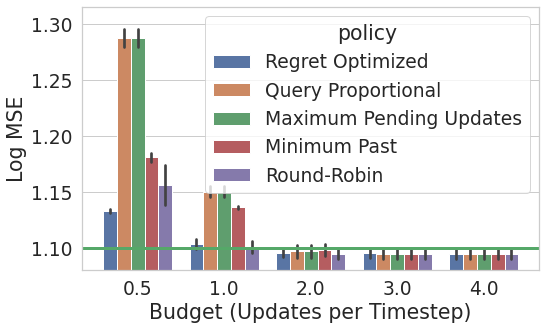

In [70]:
subset = ["total_error_cold", "min_past", "round_robin", "max_pending", "last_query", "query_proportional", "batch"]

plt = plot_factor(60, subset, updates=[0.5, 1, 2, 3, 4, 6, 8])
plt.tight_layout()
plt.savefig('/data/wooders/ralf-vldb/plots/als_1m_bar_all.pdf') 

/data/wooders/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


1.100133457706349 4101


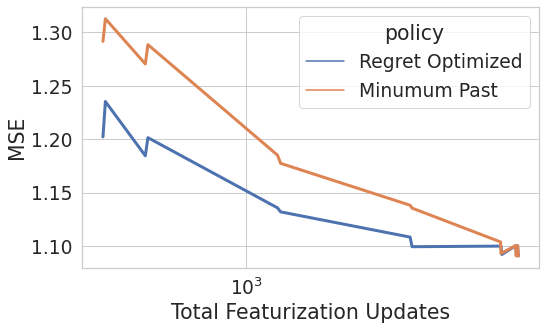

In [71]:
subset = ["total_error_cold", "min_past"] #, "round_robin", "max_pending", "last_query", "query_proportional", "batch"]

plt = plot_factor_total_updates(60, subset, log=False)
plt.tight_layout()
plt.savefig('/data/wooders/ralf-vldb/plots/als_1m_line.pdf') 

/tmp/ipykernel_3092022/1439645019.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df.policy = plot_df.policy.map({


1.1169459005554807 25497


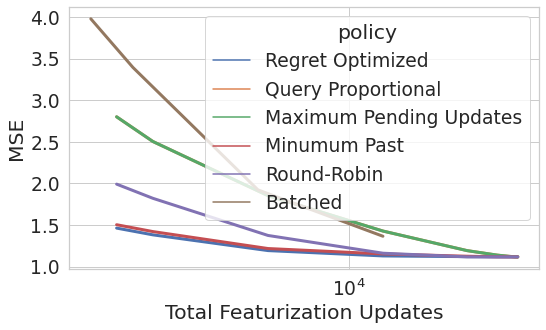

In [55]:
subset = ["total_error_cold", "min_past", "round_robin", "max_pending", "last_query", "query_proportional", "batch"]

plt = plot_factor_total_updates(60, subset, log=False)
plt.tight_layout()
plt.savefig('/data/wooders/ralf-vldb/plots/als_1m_line_all.pdf') 

## Plot Rate of Updates vs. Error Improvement 

In [ ]:
window_size = 1 
ts_factor = 60

In [ ]:
stream_df["adj_timestamp"] = stream_df["timestamp"].apply(lambda x: int(x/60))
start_ts = stream_df.adj_timestamp.min()
end_ts = stream_df.adj_timestamp.max()

print(start_ts, end_ts)

In [ ]:
count_df = stream_df.groupby("adj_timestamp").user_id.nunique().to_frame()

In [ ]:
count_df = stream_df.groupby("adj_timestamp").user_id.nunique().to_frame()
time_df = pd.Series(range(start_ts, end_ts, 1)).to_frame("timestamp").merge(count_df, how="left", left_on="timestamp", right_on="adj_timestamp").fillna(0)
user_update_rate_df = time_df.user_id.rolling(window_size).sum()

In [ ]:
user_update_rate_df.plot()

In [ ]:
count_df = stream_df.groupby("adj_timestamp").user_id.count().to_frame()
time_df = pd.Series(range(start_ts, end_ts, 1)).to_frame("timestamp").merge(count_df, how="left", left_on="timestamp", right_on="adj_timestamp").fillna(0)

rating_update_rate_df = pd.DataFrame()
rating_update_rate_df["n"] = time_df.user_id.rolling(window_size).sum()
rating_update_rate_df["timestamp"] = time_df.timestamp.rolling(window_size).max().fillna(0)

In [ ]:
rating_update_rate_df.n.plot()

In [ ]:
eval_df = df_all[df_all["ts_factor"] == ts_factor]
eval_df["error_diff"] = (eval_df["y_pred"] - eval_df["y_true"]).pow(2)
eval_df

In [ ]:
eval_df = df_all[df_all["ts_factor"] == ts_factor]
eval_df["error_diff"] = (eval_df["y_pred"] - eval_df["y_true"]).pow(2)

records = []
for (updates, policy, ts), group in tqdm(eval_df.groupby(["updates", "policy", "timestamp"])): 
    records.append({
        "updates": updates, 
        "policy": policy, 
        "timestamp": ts, 
        "error": group.error_diff.mean()
    })

    
    
print("finished group")
ts_error_df = pd.DataFrame(records)
print(ts_error_df)

In [ ]:
ts_error_df.to_csv(f"{result_dir}/error_time_{ts_factor}.csv")

In [ ]:
error_window_df = ts_error_df.reset_index()

In [ ]:
min_past_df = error_window_df[error_window_df["policy"] == "min_past"].groupby(["updates", "timestamp"]).error.min().to_frame().reset_index()
max_pending_df = error_window_df[error_window_df["policy"] == "max_pending"].groupby(["updates", "timestamp"]).error.min().to_frame().reset_index()
optimized_df = error_window_df[error_window_df["policy"] == "total_error_cold"].groupby(["updates", "timestamp"]).error.min().to_frame().reset_index()

In [ ]:
updates = 0.2

improvement_min_past = min_past_df[min_past_df["updates"] == updates].error - optimized_df[optimized_df["updates"] == updates].error
improvement_max_pending = max_pending_df[max_pending_df["updates"] == updates].error - optimized_df[optimized_df["updates"] == updates].error

In [ ]:
total_counts = []
for ts in tqdm(baseline_df[baseline_df["updates"] == updates].timestamp.tolist()):
    if ts >= 60: 
        total_count = time_df[(time_df["timestamp"] > ts - 60) & (time_df["timestamp"] <= ts)].user_id.unique().sum()
        total_counts.append(total_count)
        
    if len(total_counts) >= 100000:
        break

In [ ]:
improvement

In [ ]:
min_past_df = pd.DataFrame({"update_rate": total_counts, "improvement": improvement_min_past.rolling(60).mean().tolist()[58:], "policy": "Minimum Past"})
max_pending_df = pd.DataFrame({"update_rate": total_counts, "improvement": improvement_max_pending.rolling(60).mean().tolist()[58:], "policy": "Maximum Pending"})

plot_df = pd.concat([min_past_df, max_pending_df])
plot_df

In [ ]:
plt.tight_layout()

g=sns.lmplot(x="update_rate", y="improvement", hue="policy", data=plot_df, order=2, scatter=False, legend=False, height=5, aspect=1.5)

g.set(title="Improvement (Recommendation)", xlabel="Hourly Unique User Ratings",  ylabel="MSE")

g.despine(left=True)
plt.legend(loc='lower center')

results_df.to_csv(f"/data/wooders/ralf-vldb/plots/als_improvements.csv")
plt.savefig('/data/wooders/ralf-vldb/plots/als_1m_improvement_rate.pdf')

In [ ]:
plot_df = pd.DataFrame({"update_rate": total_counts, "improvement": improvement_max_pending.rolling(60).mean().tolist()[58:]})

sns.regplot(x="update_rate", y="improvement", data=plot_df, order=2, scatter=False)

In [ ]:
plot_df = pd.DataFrame({"update_rate": total_counts, "improvement": improvement_min_past.rolling(60).mean().tolist()[58:]})

sns.regplot(x="update_rate", y="improvement", data=plot_df, order=2, scatter=False)

In [ ]:
f, ax = plt.subplots(ncols=1, figsize=(5, 5))
plt.tight_layout()

plot_df = pd.DataFrame({"update_rate": total_counts, "improvement": improvement_max_pending.rolling(60).mean().tolist()[58:]})

sns.regplot(x="update_rate", y="improvement", data=plot_df, order=2, scatter=False, ax=ax, label="Max Pending", x_bins=100)

ax.set(title="Mean Improvement per Hour", xlabel="Unique Users per Hour",  ylabel="MSE")
ax.legend()
plt.savefig('/data/wooders/ralf-vldb/plots/als_1m_improvement_max_pending.pdf')

In [ ]:
f, ax = plt.subplots(ncols=1, figsize=(5, 5))
plt.tight_layout()

plot_df = pd.DataFrame({"update_rate": total_counts, "improvement": improvement_min_past.rolling(60).mean().tolist()[58:]})

sns.regplot(x="update_rate", y="improvement", data=plot_df, order=2, scatter=False, ax=ax, label="Max Pending", x_bins=100)

ax.set(title="Mean Improvement per Hour", xlabel="Unique Users per Hour",  ylabel="MSE")
ax.legend()
plt.savefig('/data/wooders/ralf-vldb/plots/als_1m_improvement_min_past.pdf')

In [ ]:
f, ax = plt.subplots(ncols=1, figsize=(5, 5))
plt.tight_layout()

plot_df = pd.DataFrame({"update_rate": total_counts, "improvement": improvement_min_past.rolling(60).mean().tolist()[58:]})

sns.regplot(x="update_rate", y="improvement", data=plot_df, order=6, scatter=False, ax=ax, label="Minimum Past")

ax.set(title="Mean Improvement per Hour", xlabel="Unique Users per Hour",  ylabel="MSE")
ax.legend()

In [ ]:
plot_df = pd.DataFrame({ 
    #"timestamp": rating_update_rate_df.iloc[:1000].timestamp, 
    "update_rate":  rating_update_rate_df.iloc[:100000].n,
    "improvement": improvement.iloc[:100000]
})
plot_df = pd.DataFrame({
    "update_rate": plot_df.groupby("update_rate").groups.keys(), 
    "improvement": plot_df.groupby("update_rate").improvement.mean()
})


sns.regplot(x="update_rate", y="improvement", data=plot_df, order=2)

In [ ]:
sns.scatterplot(x="update_rate", y="improvement", data=plot_df)

In [ ]:
plot_df.groupby("update_rate").groups.keys()

In [ ]:
plot_df = pd.DataFrame({ 
    "timestamp": rating_update_rate_df.iloc[window_size:10000+window_size].timestamp, 
    "update_rate":  rating_update_rate_df.iloc[window_size:10000+window_size].n,
    "improvement": improvement.iloc[0:10000]
})

sns.regplot(x="update_rate", y="improvement", data=plot_df)

In [ ]:
optimized_df[optimized_df["updates"] == 0.2].iloc[:1000].error.mean()

In [ ]:
baseline_df[baseline_df["updates"] == 0.2].iloc[:1000].error.mean()

In [ ]:
error_window_df[(error_window_df["updates"] == 0.2) & (error_window_df["policy"] == "total_error_cold")].error.plot()

In [ ]:
error_window_df

In [ ]:
error_window_df = eval_df.groupby(["policy", "updates"]) \
    .apply(lambda x: x.error_diff.rolling(window_size).sum())#lambda x: mean_absolute_error(x.y_pred, x.y_true)*x.y_pred.count() if x.y_pred.count() > 0 else 0)

In [ ]:
error_window_df = error_window_df.reset_index()

In [ ]:
error_window_df

In [ ]:
optimized_window_error = error_window_df[error_window_df["policy"] == "total_error_cold"]
optimized_window_error

In [ ]:
baseline_window_error = error_window_df[error_window_df["policy"] != "total_error_cold"].groupby("updates").apply(lambda x: x.iloc[:, 2:].min()).reset_index()
baseline_window_error

In [ ]:
updates = 0.2

baseline = (baseline_window_error[baseline_window_error["updates"] == updates].iloc[0, 1:]).to_list()
optimized = (optimized_window_error[optimized_window_error["updates"] == updates].iloc[0, 2:]).to_list()

improvement_df = pd.DataFrame({"baseline": baseline, "optimized": optimized})
improvement_df["improvement"] = improvement_df["baseline"] - improvement_df["optimized"]
improvement_df

In [ ]:
improvement_df.improvement.plot()

In [ ]:
eval_df = df_all[df_all["ts_factor"] == ts_factor]
error_dfs = []
improvement_df = []
for t in tqdm(range(start_ts, end_ts, window_size)): 
    eval_t_df = eval_df[(eval_df["timestamp"] >= t) & (eval_df["timestamp"] < t+window_size)]
    
    if len(eval_t_df.index) == 0: continue
    
    group_df = eval_t_df.groupby(["policy", "updates"])
    error_t_df = group_df.apply(lambda x: mean_absolute_error(x.y_pred, x.y_true)*x.y_pred.count() if x.y_pred.count() > 0 else 0)
    #error_t_df = group_df.apply(lambda x: mean_absolute_error(x.y_pred, x.y_true) if x.y_pred.count() > 0 else 0)

    error_t_df = error_t_df.reset_index(name="error")
    error_t_df["timestamp_idx"] = int(t/window_size)
    error_dfs.append(error_t_df)
    
    
    impr_df = pd.DataFrame()
    impr_df["baseline"] = error_t_df[error_t_df["policy"] != "total_error_cold"].groupby("updates").error.min()
    impr_df["regret_optimized"] = error_t_df[error_t_df["policy"] == "total_error_cold"].groupby("updates").error.min()
    impr_df["timestamp_hr"] = int(t/60)
    impr_df["timestamp"] = t+60
    improvement_df.append(impr_df)
    
    
    

error_df = pd.concat(error_dfs)
improvement_df = pd.concat(improvement_df)
error_df

In [ ]:
u_df = updates_df[(updates_df["ts_factor"] == 60) &(updates_df["policy"] == "round_robin")]

In [ ]:
ts_factor = 60
single_update_df = updates_df[(updates_df["ts_factor"] == 60) &(updates_df["policy"] == "round_robin")]
single_update_df = single_update_df.groupby("time").runtime.count().reset_index()
stream_df["adj_timestamp"] = stream_df["timestamp"].apply(lambda x: int(x/60))
all_update_df = pd.DataFrame()
all_update_df["user_updates"] = stream_df.groupby("adj_timestamp").user_id.nunique()
all_update_df["rating_updates"] = stream_df.groupby("adj_timestamp").user_id.count()
print(all_update_df)
print(single_update_df)

In [ ]:
update_time_df = all_update_df.merge(single_update_df, how="left", left_on="adj_timestamp", right_on="time")
print(update_time_df)
update_time_df = update_time_df[["time", "user_updates", "rating_updates", "runtime"]]
update_time_df.columns = ["timestamp", "user_updates", "rating_updates", "updates"]
update_time_df

In [ ]:

sns.scatterplot(x='timestamp', y='rating_updates', data=update_time_df[update_time_df["timestamp"] < 10000])
sns.scatterplot(x='timestamp', y='user_updates', data=update_time_df[update_time_df["timestamp"] < 10000])

In [ ]:
plt.tight_layout()
f, ax = plt.subplots(ncols=1, figsize=(10, 5))
sns.set_theme(style="whitegrid", font_scale=1.7)

sns.regplot(x='timestamp', y='rating_updates', data=update_time_df[update_time_df["timestamp"] < 10000], order=10, label="Number Ratings", x_bins=20, ax=ax)
sns.regplot(x='timestamp', y='user_updates', data=update_time_df[update_time_df["timestamp"] < 10000], order=10, label="Number Unique Users", x_bins=100, ax=ax)

ax.set(title="Incoming Data Rate per Minute (Recommendation)", xlabel="Timestep (minutes)",  ylabel="Count")
ax.legend()

In [ ]:
plt.tight_layout()
f, ax = plt.subplots(ncols=1, figsize=(10, 5))
sns.set_theme(style="whitegrid", font_scale=1.7)

sns.scatterplot(x='timestamp', y='rating_updates', data=update_time_df[update_time_df["timestamp"] < 10000], label="Number Ratings", ax=ax)
sns.scatterplot(x='timestamp', y='user_updates', data=update_time_df[update_time_df["timestamp"] < 10000], label="Number Unique Users", ax=ax)

ax.set(title="Incoming Data Rate per Minute (Recommendation)", xlabel="Timestep (minutes)",  ylabel="Count")
ax.legend()

In [ ]:
df_all

In [ ]:
df_all

In [ ]:
eval_df = df_all[df_all["ts_factor"] == 60]
error_dfs = []
improvement_df = []
for t in tqdm(range(0, 10000, 60)): 
    eval_t_df = eval_df[(eval_df["timestamp"] >= t) & (eval_df["timestamp"] < t+60)]
    
    if len(eval_t_df.index) == 0: continue
    
    group_df = eval_t_df.groupby(["policy", "updates"])
    error_t_df = group_df.apply(lambda x: mean_absolute_error(x.y_pred, x.y_true)*x.y_pred.count() if x.y_pred.count() > 0 else 0)
    #error_t_df = group_df.apply(lambda x: mean_absolute_error(x.y_pred, x.y_true) if x.y_pred.count() > 0 else 0)

    error_t_df = error_t_df.reset_index(name="error")
    error_t_df["timestamp_hr"] = t/60
    error_dfs.append(error_t_df)
    
    
    impr_df = pd.DataFrame()
    impr_df["baseline"] = error_t_df[error_t_df["policy"] != "total_error_cold"].groupby("updates").error.min()
    impr_df["regret_optimized"] = error_t_df[error_t_df["policy"] == "total_error_cold"].groupby("updates").error.min()
    impr_df["timestamp_hr"] = int(t/60)
    impr_df["timestamp"] = t+60
    improvement_df.append(impr_df)
    
    
    

error_df = pd.concat(error_dfs)
improvement_df = pd.concat(improvement_df)
error_df

In [ ]:
improvement_df = improvement_df.reset_index()

In [ ]:
improvement_df["total_error_change"] = improvement_df["baseline"] - improvement_df["regret_optimized"]

In [ ]:
plt.tight_layout()
sns.set_theme(style="whitegrid", font_scale=1.7)
plot_df = improvement_df
plot_df["total_error_change"] = improvement_df["baseline"] - improvement_df["regret_optimized"]
plot_df["Updates per Hour"] = (plot_df["updates"] * 60).astype(int)
ax = sns.lmplot(x="timestamp", y="total_error_change", hue="Updates per Hour", col="Updates per Hour", col_wrap=2, order=10, data=plot_df)
ax.set(xlabel="Timestep (minutes)",  ylabel="Total Error", ylim=(-30, 60))

ax.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
ax.fig.suptitle("Hourly Total Error Improvement (Recommendation)")

In [ ]:
df = improvement_df.merge(update_time_df, how="left", on=["timestamp", "updates"])

In [ ]:
df.rating_updates.value_counts()

In [ ]:
plt.tight_layout()
sns.set_theme(style="whitegrid", font_scale=1.7)
ax = sns.regplot(x="timestamp", y="total_error_change", order=10, data=improvement_df)
ax.set(title="Total Error Improvement per Hour (Recommendation)", xlabel="Timestep (minutes)",  ylabel="Total Error")

In [ ]:
improvement_df[improvement_df["total_error_change"] < -100]

In [ ]:
sns.scatterplot(x='timestamp', y='ratings', data=update_time_df[update_time_df["timestamp"] < 10000])
sns.scatterplot(x='timestamp', y='updates', data=update_time_df[update_time_df["timestamp"] < 10000])

In [ ]:
sns.regplot(x='timestamp', y='ratings', data=update_time_df[update_time_df["timestamp"] < 10000], order=10)

In [ ]:
update_time_df["timestamp_hr"] = update_time_df["timestamp"].apply(lambda x: int(x/60))
update_agg_df = update_time_df.groupby("timestamp_hr").ratings.sum().reset_index(name="user_updates")
print(update_agg_df)
sns.lineplot(x='timestamp', y='user_updates', data=update_agg_df[update_agg_df["timestamp_hr"] < 160])

In [ ]:
diff_df = error_df[error_df["policy"] != "total_error_cold"]
diff_df = diff_df.merge(error_df[error_df["policy"] == "total_error_cold"], how="left", on="timestamp", suffixes=('', '_baseline')).reset_index()
diff_df["error_improvement"] = diff_df["error"] - diff_df["error_baseline"]
sns.lineplot(x="timestamp", y="error_improvement", hue="policy", data=diff_df)

In [ ]:
#f, ax = plt.subplots(ncols=1, figsize=(10, 5))
plt.tight_layout()
#sns.set_theme(style="whitegrid", font_scale=1.7)
ts_factor_filter = 60

subset = ["total_error_cold", "min_past", "round_robin", "max_pending"]
#subset = ["total_error_cold", "min_past", "max_pending"]

diff_df = error_df[error_df["policy"] != "total_error_cold"]
diff_df = diff_df.merge(error_df[error_df["policy"] == "total_error_cold"], how="left", on="timestamp_hr", suffixes=('', '_baseline')).reset_index()
diff_df["error_improvement"] = diff_df["error"] - diff_df["error_baseline"]

plot_df = diff_df[diff_df.policy.isin(subset)]
plot_df.policy = plot_df.policy.map({
    'total_error_cold': 'Regret Optimized', 
    'min_past': 'Minimum Past Updates', 
    'round_robin': "Round-Robin", 
    'max_pending': "Maximum Pending Updates", 
    'last_query': "Read-Optimized", 
    "query_proportional": "Query Proportional",
    "batch": "Batched"
})
#sns.scatterplot(x="timestamp_hr", y="error_improvement", hue="policy", data=plot_df, ax=ax)
g = sns.lmplot(x="timestamp_hr", y="error_improvement", hue="policy", aspect=2, data=plot_df, order=10)
#g.set(ylim=(-1000, 6000))
ax.set(title="Total Error Improvement per Hour (Recommendation)", xlabel="Timestep (hours)",  ylabel="Total Squared Error")

In [ ]:
data_df = error_df[(error_df["policy"] == "total_error_cold") | (error_df["policy"] == "min_past")].reset_index()
data_df["error"] = np.log(data_df["error"])
sns.lineplot(x="timestamp", y="error", hue="policy", data=data_df)

In [ ]:
data_df = error_df[(error_df["policy"] == "total_error_cold") | (error_df["policy"] == "query_proportional")].reset_index()
data_df["error"] = np.log(data_df["error"])
sns.lineplot(x="timestamp", y="error", hue="policy", data=data_df)

In [ ]:
f, ax = plt.subplots(ncols=2, figsize=(10, 5))
plt.tight_layout()
sns.set_theme(style="whitegrid", font_scale=1.2)
ts_factor = 10 

plot_df = results_df[(results_df["ts_factor"] == 10) & (results_df.policy.isin(["total_error_cold", "min_past", "round_robin", "max_pending", "last_query"]))]
plot_df.policy = plot_df.policy.map({
    'total_error_cold': 'Regret Optimized', 
    'min_past': 'Minimum Past Updates', 
    'round_robin': "Round-Robin", 
    'max_pending': "Maximum Pending Updates", 
    'last_query': "Read-Optimized"
})
plot_df = plot_df.dropna()
sns.barplot(x="updates", y="error", hue="policy", data=plot_df, log=True, ax=ax[0])

plot_df = plot_df[plot_df.policy.isin(['Minimum Past Updates', 'Regret Optimized'])].reset_index()
print(plot_df)
sns.barplot(x="updates", y="error", hue="policy", data=plot_df, log=True, ax=ax[1])

ax[1].set(title="Prediction Accuracy per Policy (Recommendation)", xlabel="Updates per Timestep",  ylabel="Log MSE")
ax[1].set(title="Prediction Accuracy per Policy (Recommendation)", xlabel="Updates per Timestep",  ylabel="MSE")
#plt.legend(np.flip(plot_df['policy'].unique()), loc='upper right', title="Event Type")

In [ ]:
ax = sns.barplot(x="updates", y="error", hue="policy", data=results_df[results_df["ts_factor"] == 10], log=True)

In [ ]:
updates_df.key.value_counts()

In [ ]:
updates_df[(updates_df["time"] > ts_min) & (updates_df["time"] < ts_max) & (updates_df["updates"] == updates) & (updates_df["ts_factor"] == 10)].key.value_counts()

In [ ]:
df_all[(df_all.index > ts_min) & (df_all.index < ts_max) & (df_all["updates"] == updates) & (df_all["ts_factor"] == 10)].user_id.value_counts()

In [ ]:
updates_df

In [ ]:
ts_min = 35000
ts_max = 40000
updates=1

In [ ]:
df_all[(df_all["updates"] == updates) & (df_all["ts_factor"] == 10)].groupby("timestamp").updates.count().plot()


In [ ]:
hist_df = updates_df[(updates_df["time"] > ts_min) & (updates_df["time"] < ts_max) & (updates_df["updates"] == updates) & (updates_df["ts_factor"] == 10)].groupby(by=["key", "policy"]).updates.count().reset_index()
hist_df["user_id"] = hist_df["key"]
hist_df["policy"] = hist_df.policy.map({
    'total_error_cold': 'Accuracy Optimized', 
    'min_past': 'Minimum Past Updates', 
    'round_robin': "Round Robin", 
    'max_pending': "Maximum Pending"
})
hist_df = hist_df.dropna()
hist_df.user_id.value_counts()

samples_df = df_all[(df_all["timestamp"] > ts_min) & (df_all.index < ts_max) & (df_all["updates"] == updates) & (df_all["ts_factor"] == 10)]\
    .groupby(by=["user_id", "policy"])\
    .ts_factor.count()\
    .to_frame(name="samples")\
    .reset_index()

In [ ]:
# samples_df = df_all[(df_all.index > ts_min) & (df_all.index < ts_max) & (df_all["updates"] == updates) & (df_all["ts_factor"] == 10)].groupby(by=["user_id", "policy"]).ts_factor.count().to_frame(name="samples")
# ratio_df = pd.DataFrame(samples_df).join(hist_df.set_index(["user_id", "policy"]), on=["user_id", "policy"]).reset_index()
# hist_df = updates_df[(updates_df["time"] > ts_min) & (updates_df["time"] < ts_max) & (updates_df["updates"] == updates) & (updates_df["ts_factor"] == 10)].groupby(by=["key", "policy"]).updates.count().reset_index()
# hist_df["user_id"] = hist_df["key"]
# print(ratio_df)
# ratio_df["policy"] = ratio_df.policy.map({
#     'total_error_cold': 'Accuracy Optimized', 
#     'min_past': 'Minimum Past Updates', 
#     'round_robin': "Round Robin", 
#     'max_pending': "Maximum Pending"
# })
# ratio_df = ratio_df.dropna().reset_index()
# ratio_df["ratio"] = ratio_df.apply(lambda x: x["updates"]/x["samples"], axis=1)

# sns.set_theme(style="whitegrid", font_scale=1.5)
# g = sns.histplot(data=ratio_df, x="updates", hue="policy", discrete=False)
# g.set(title="Distribution of Updates Across Keys", xlabel="Scheduled Updates per Key",  ylabel="Number Keys")

In [ ]:
heat_df = hist_df.pivot("policy", "user_id", "updates").sort_values("Round Robin", axis=1, ascending=False).fillna(0)
heat_df

In [ ]:
heat_df = hist_df.pivot("policy", "user_id", "updates").sort_values("Round Robin", axis=1, ascending=False).fillna(0)
f, ax = plt.subplots(figsize=(10, 5))
plt.tight_layout()
sns.set_theme(style="whitegrid", font_scale=1.7)

sns.heatmap(
    heat_df.iloc[:, :20], 
    annot=True, 
    cbar=False,  
    yticklabels=["Regret Optimized", "Maximum Pending", "Minimum Past", "Round Robin"],
    xticklabels=range(1, 21, 1),
    square=True,
    ax=ax
)
ax.set_xlabel(f"Most Updated Users (Timestamps {ts_min}-{ts_max})")
ax.set_ylabel(None)
ax.set_title("Number of Featurization Updates")
#plt.legend(fontsize='x-large')
f.savefig('/data/wooders/ralf-vldb/plots/als_heatmap.pdf', dpi=300, bbox_inches = "tight")

In [ ]:
heat_df = hist_df.pivot("policy", "user_id", "updates").sort_values("Round Robin", axis=1, ascending=False).fillna(0)
f, ax = plt.subplots(nrows=2, figsize=(20, 10))
sns.heatmap(
    heat_df.iloc[:, :20], 
    annot=True, 
    cbar=False,  
    #yticklabels=["Regret Optimized", "Minimum Past", "Round Robin"],
    xticklabels=range(1, 21, 1),
    square=True,
    ax=ax[0]
)
ax[0].set_xlabel("Most Updated Users")
ax[0].set_ylabel(None)
ax[0].set_title("Featurization Updates")

users = heat_df.columns[1:21]
print(users)
samples = [samples_df[samples_df["user_id"] == u].samples.max() for u in users]
d = pd.DataFrame({"User": range(1, 21, 1), "Raw Data Updates": samples})
print(d)
#d = pd.DataFrame([samples], columns=users, index=["Total Data Points"])
sns.barplot(data=d, x="User", y="Raw Data Updates", ax=ax[1])
#ax[1].set_ylabel(None)
#ax[1].set_title("Raw Data Updates Updates")

In [ ]:
key_df = updates_df[(updates_df["key"] == 2693) & (updates_df["ts_factor"] == 10) & (updates_df["updates"] == 1)]
key_df = key_df.set_index(["time", "policy"]).reset_index()
sns.histplot(key_df, x="time", hue="policy")

In [ ]:
for (i, (key, group)) in enumerate(key_df.groupby("policy")):
    group = group.time.tolist()
    x = group
    y = range(1, len(group) + 1, 1)
    plt.plot(x, y, label=key)
plt.legend()
    

In [ ]:
samples_df[samples_df["user_id"] == 3437]

In [ ]:
heat_df = hist_df.pivot("policy", "user_id", "updates").sort_values("Round Robin", axis=1, ascending=False).fillna(0)
f, ax = plt.subplots(nrows=2, figsize=(20, 10))
sns.heatmap(
    heat_df.iloc[:, :20], 
    annot=True,
    cbar=False,  
    #yticklabels=["Regret Optimized", "Minimum Past", "Round Robin"],
    xticklabels=range(1, 21, 1),
    square=True,
    ax=ax[0]
)
ax[0].set_xlabel("Most Updated Users")
ax[0].set_ylabel(None)
ax[0].set_title("Featurization Updates")

heat_df = hist_df.pivot("policy", "user_id", "updates").sort_values("Round Robin", axis=1, ascending=True).fillna(0)
sns.heatmap(
    heat_df.iloc[:, :20], 
    annot=True, 
    cbar=False,  
    #yticklabels=["Regret Optimized", "Minimum Past", "Round Robin"],
    xticklabels=range(1, 21, 1),
    square=True,
    ax=ax[1]
)
ax[1].set_xlabel("Least Updated Users")
ax[1].set_ylabel(None)
ax[1].set_title("Featurization Updates")

In [ ]:
users = heat_df.columns[1:21]
samples = [ratio_df[ratio_df["user_id"] == u].samples.max() for u in users]
d = pd.DataFrame({"User": range(1, 21, 1), "Raw Data Updates": samples})
print(d)
#d = pd.DataFrame([samples], columns=users, index=["Total Data Points"])
sns.barplot(data=d, x="User", y="Raw Data Updates")

In [ ]:
#f, ax = plt.subplots(figsize=(20, 2))

#fig, axs = plt.subplots(2, figsize=(20, 6))
fig, axs = plt.subplots(nrows=3)

fig.suptitle('Vertically stacked subplots')

heat_df = ratio_df.pivot("policy", "user_id", "ratio").fillna(0)
sns.heatmap(heat_df.iloc[:, :10], ax=axs[0]) #, square=True, annot=True, cbar=False)

heat_df = ratio_df.pivot("policy", "user_id", "updates").sort_values("Accuracy Optimized", axis=1, ascending=False).fillna(0)
sns.heatmap(heat_df.iloc[:, :10], ax=axs[1], annot=True)

heat_df = ratio_df.pivot("policy", "user_id", "samples").fillna(0)
sns.heatmap(heat_df.iloc[:, :10], ax=axs[2])


In [ ]:
runtime = 1.0
sns.set(rc={'figure.figsize':(10.7,5.27)})
hist_df = updates_df[updates_df["runtime"] == runtime].groupby(by=["key", "policy"]).size()
hist_df = hist_df / samples_df
print(hist_df.max())
hist_df = hist_df.to_frame(name="updates").reset_index()
print(hist_df.policy.value_counts())
hist_df["policy"] = hist_df.policy.map({'total_error_cold': 'Accuracy Optimized', 'min_past': 'Minimum Past Updates', 'round_robin': "Round Robin"})
hist_df = hist_df.dropna()
print(hist_df.max())

sns.set_theme(style="whitegrid", font_scale=1.5)
g = sns.histplot(data=hist_df, x="updates", hue="policy", log_scale=(False, True), discrete=False, bins=30)
g.set(title="Distribution of Updates Across Keys", xlabel="Scheduled Updates per Key",  ylabel="Number Keys")

In [ ]:
updates_df[(updates_df["policy"] == "total_error") & (updates_df["runtime"] == 1.00)]

# Plot Dataset

In [ ]:
factor = 100

In [ ]:
test_df = pd.read_csv(f'{dataset_dir}/stream.csv')
train_df = pd.read_csv(f'{dataset_dir}/train.csv')
start_ts = test_df.timestamp.min()
past_updates = pickle.load(open(f"{result_dir}/past_updates.pkl", "rb"))
test_df.timestamp = test_df.timestamp.apply(lambda ts: int((ts - start_ts)/factor))

In [ ]:
new_user_df = test_df[test_df.user_id.isin(past_updates.keys())]
old_user_df = test_df[~test_df.user_id.isin(past_updates.keys())]

In [ ]:
old_user_df.groupby(by="timestamp").user_id.nunique().plot(label="old_user").legend()
new_user_df.groupby(by="timestamp").user_id.nunique().plot(label="new_user").legend()

In [ ]:
old_user_df.groupby(by="timestamp").rating.count().rolling(1000).mean().plot(label="old_user")
new_user_df.groupby(by="timestamp").rating.count().rolling(1000).mean().plot(label="new_user").legend()

In [ ]:
test_df.groupby(by="timestamp").count().rolling(window=100).mean().plot()

In [ ]:
train_df.movie_id.value_counts()

In [ ]:
test_df.movie_id.value_counts()

# Results Over Time 

In [ ]:
results[0]

In [ ]:
x0 = 0 #190000#test_df.timestamp.min()
x1 = 200000 #test_df.timestamp.max()

p = "min_past"
u = 1
t = 100
df = df_all[(df_all["policy"] == p) & (df_all["ts_factor"] == t) & (df_all["updates"] == u)]
df["square_error"] = df.y_pred - df.y_true
df["square_error"] = df["square_error"].apply(lambda x: x*x)
print(df.square_error.mean())
df[(df["timestamp"] < x1) & (df["timestamp"] > x0)].groupby(by="timestamp").square_error.sum().plot(label=p) #rolling(1000).mean().plot(xlim=(x0, x1), label=p)
min_past_df = df

p = "total_error_cold"
df = df_all[(df_all["policy"] == p) & (df_all["ts_factor"] == t) & (df_all["updates"] == u)]
df["square_error"] = df.y_pred - df.y_true
df["square_error"] = df["square_error"].apply(lambda x: x*x)
print(df.square_error.mean())
df[(df["timestamp"] < x1) & (df["timestamp"] > x0)].groupby(by="timestamp").square_error.sum().plot(label=p).legend() #rolling(1000).mean().plot(xlim=(x0, x1), label=p)
total_error_df = df
#p = "total_error"
#df = df_all[(df_all["policy"] == p) & (df_all["ts_factor"] == t) & (df_all["updates"] == u)]
#df["square_error"] = df.y_pred - df.y_true
#df["square_error"] = df["square_error"].apply(lambda x: x*x)
#df[(df["timestamp"] < x1) & (df["timestamp"] > x0) ].groupby(by="timestamp").square_error.sum().rolling(100).mean().plot(label=p).legend() #rolling(1000).mean().plot(xlim=(x0, x1), label=p)


df

In [ ]:
min_past_df

In [ ]:
diff_df = pd.concat([total_error_df, min_past_df]).drop_duplicates(keep=False, subset=["timestamp", "user_id", "movie_id", "square_error"])

In [ ]:
diff_df.groupby(by=["user_id"]).square_error.sum()

In [ ]:
update_table = updates_df[(updates_df["ts_factor"] == t) & (updates_df["updates"] == u)]\
                            .groupby(by=["key", "policy"])\
                            .time.apply(np.array)
                            
update_table

In [ ]:
update_table.loc[1].loc["last_query"]

In [ ]:
df = df_all[(df_all["ts_factor"] == t) & (df_all["updates"] == u)]
df["square_error"] = df.y_pred - df.y_true
df["square_error"] = df["square_error"].apply(lambda x: x*x)
df.square_error.max()

In [ ]:
df.groupby(by="policy").square_error.mean()

In [ ]:
df[~df.user_id.isin(past_updates.keys())].groupby(by="policy").square_error.mean()

In [ ]:
df[df.user_id.isin(past_updates.keys())].groupby(by="policy").square_error.mean()

In [ ]:
df.groupby(by="user_id").y_true.count()

In [ ]:
for user_id, group in df.groupby(by=["user_id"]):
    #print(group)
    te = group[group["policy"] == "total_error_cold"].square_error.sum()
    mp = group[group["policy"] == "min_past"].square_error.sum()
    if te > mp*1.1: 
        print(user_id, past_updates[user_id], te, mp)
        print("    total_error", update_table.loc[user_id].loc["total_error_cold"].mean(), update_table.loc[user_id].loc["total_error_cold"].shape)
        print("    min_past", update_table.loc[user_id].loc["min_past"].mean(), update_table.loc[user_id].loc["min_past"].shape)

In [ ]:
for user_id, group in diff_df.groupby(by=["user_id"]):
    #print(group)
    te = group[group["policy"] == "total_error_cold"].square_error.sum()
    mp = group[group["policy"] == "min_past"].square_error.sum()
    if te*1.1 < mp: 
        print(user_id, past_updates[user_id] if user_id in past_updates else False, te, mp)
        print("    total_error", update_table.loc[user_id].loc["total_error_cold"].mean(), update_table.loc[user_id].loc["total_error_cold"].shape)
        print("    min_past", update_table.loc[user_id].loc["min_past"].mean(), update_table.loc[user_id].loc["min_past"].shape)

In [ ]:
x0 = test_df.timestamp.min()
x1 = test_df.timestamp.max()

p = "max_pending"
u = 1
t = 100
df = pd.read_csv(f"{result_dir}/{p}_{u}_{t}_results.csv")
df["square_error"] = df.y_pred - df.y_true
df["square_error"] = df["square_error"].apply(lambda x: x*x)
#df.groupby(by="timestamp").square_error.mean().rolling(1000).mean().plot(xlim=(x0, x1))

p = "total_error_cold"
df = pd.read_csv(f"{result_dir}/{p}_{u}_{t}_results.csv")
df["square_error"] = df.y_pred - df.y_true
df["square_error"] = df["square_error"].apply(lambda x: x*x)
df.groupby(by="timestamp").square_error.mean().expanding().sum().plot(xlim=(x0, x1), label=p)


p = "min_past"
df = pd.read_csv(f"{result_dir}/{p}_{u}_{t}_results.csv")
df["square_error"] = df.y_pred - df.y_true
df["square_error"] = df["square_error"].apply(lambda x: x*x)
df.groupby(by="timestamp").square_error.mean().expanding().sum().plot(xlim=(x0, x1), label=p).legend()

p = "max_pending"
df = pd.read_csv(f"{result_dir}/{p}_{u}_{t}_results.csv")
df["square_error"] = df.y_pred - df.y_true
df["square_error"] = df["square_error"].apply(lambda x: x*x)
df.groupby(by="timestamp").square_error.mean().expanding().sum().plot(xlim=(x0, x1), label=p).legend()

p = "round_robin"
df = pd.read_csv(f"{result_dir}/{p}_{u}_{t}_results.csv")
df["square_error"] = df.y_pred - df.y_true
df["square_error"] = df["square_error"].apply(lambda x: x*x)
df.groupby(by="timestamp").square_error.mean().expanding().sum().plot(xlim=(x0, x1), label=p).legend()



df

In [ ]:
p = "min_past"
df = pd.read_csv(f"{result_dir}/{p}_{u}_{t}_results.csv")
df[df["y_pred"] > 10]

In [ ]:
x0 = test_df.timestamp.min()
x1 = 1000 #100000


p = "min_past"
df = pd.read_csv(f"{result_dir}/{p}_{u}_{t}_results.csv")
df["square_error"] = df.y_pred - df.y_true
df["square_error"] = df["square_error"].apply(lambda x: x*x)
df.groupby(by="timestamp").square_error.mean().rolling(1).mean().plot(xlim=(x0, x1), label=p).legend()


In [ ]:
p = "total_error_cold"
df = pd.read_csv(f"{result_dir}/{p}_{u}_{t}_results.csv")
df["square_error"] = df.y_pred - df.y_true
df["square_error"] = df["square_error"].apply(lambda x: x*x)
df.groupby(by="timestamp").square_error.mean().rolling(1).mean().plot(xlim=(x0, x1), label=p).legend()
#df[df["square_error"] > 100]

In [ ]:
import pickle

movie_features = pickle.load(open(f"{result_dir}/train_movie_features.pkl", "rb"))
user_features = pickle.load(open(f"{result_dir}/train_user_features.pkl", "rb"))
past_updates = pickle.load(open(f"{result_dir}/past_updates.pkl", "rb"))

In [ ]:
from workloads.recsys.stream_als import  predict_user_movie_rating

In [ ]:
movie_features[481][-1]

In [ ]:
predict_user_movie_rating(user_features[4312], movie_features[481])

In [ ]:
train_df[train_df["movie_id"] == 481]

In [ ]:
test_df.groupby(by="timestamp").user_id.nunique().rolling(window=1000).mean().plot()

In [ ]:
test_df.groupby(by="timestamp").user_id.nunique().plot(xlim=(x0, x1))

In [ ]:
test_df.groupby(by="timestamp").user_id.nunique().rolling(window=1000).mean().plot(xlim=(x0, x1))

In [ ]:
test_df.groupby(by="timestamp").count().plot(xlim=(x0, x1))#.rolling(window=100).mean().plot()

In [ ]:
test_df.groupby(by="timestamp").count().rolling(window=1).mean().plot(xlim=(x0, x1))